In [44]:
import requests
import json
import csv
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow import config
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer
from keras.callbacks import EarlyStopping

In [6]:
config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Get the data from Binance api

## Get

In [7]:
# You can create 'api_key.txt' file with your api key inside it (it's already in '.gitignore')
# or just replace 'api_key.txt' => '{your_api_key}'
api_key = open('api_key.txt', 'r').read()

url = 'https://api.binance.com/api/v3/klines'

symbol =  'BTCUSDT'
interval =  '1h'
limit = 1000
headers = {
    'X-MBX-APIKEY': api_key
}

# Get current date, 4 years ago
start_time = int((time.time() - 126230400) * 1000) # 126230400 seconds = 4 years
end_time = int(time.time() * 1000)

results = []

# Loop through the data until there is no more left
while True:
    # Initial request
    params = {
        'symbol': symbol, 
        'interval': interval, 
        'startTime': start_time, 
        'endTime': end_time, 
        'limit': limit
    }
    response = requests.get(url, headers=headers, params=params)

    # Check if there is any data left
    if not response.json():
        break

    # Add the data to results
    results.extend(response.json())

    # Set the start time for the next request
    start_time = int(results[-1][0]) + 1


## Define dataframe columns and create datafile

In [8]:
columns = ['open_time', 'open_price', 'high_price', 'low_price',
            'close_price', 'Volume', 'close_time', 'quote_asset_volume',
            'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

df = pd.DataFrame(results, columns=columns)


In [9]:
df = df[['open_time', 'open_price']]

with open('data.csv', 'w') as file:
    file.write(df.to_csv())

In [10]:
df

,open_time,open_price
0,1556067600000,5500.00000000
1,1556071200000,5497.75000000
2,1556074800000,5520.43000000
3,1556078400000,5531.32000000
4,1556082000000,5556.90000000
...,...,...
35005,1682280000000,27465.78000000
35006,1682283600000,27504.62000000
35007,1682287200000,27517.83000000
35008,1682290800000,27591.73000000


# Preparing data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35010 entries, 0 to 35009
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   open_time   35010 non-null  int64 
 1   open_price  35010 non-null  object
dtypes: int64(1), object(1)
memory usage: 547.2+ KB


### Split df to dates and prices

In [12]:
df_dates = df['open_time']
df_prices = df['open_price']

In [13]:
df_prices

0         5500.00000000
1         5497.75000000
2         5520.43000000
3         5531.32000000
4         5556.90000000
              ...      
35005    27465.78000000
35006    27504.62000000
35007    27517.83000000
35008    27591.73000000
35009    27590.59000000
Name: open_price, Length: 35010, dtype: object

### Change df_prices type from object to float

In [14]:
df_prices = df_prices.astype(float)

In [15]:
df_prices

0         5500.00
1         5497.75
2         5520.43
3         5531.32
4         5556.90
           ...   
35005    27465.78
35006    27504.62
35007    27517.83
35008    27591.73
35009    27590.59
Name: open_price, Length: 35010, dtype: float64

## Split into training, validation and test

In [66]:
train_valid_border =int(len(df_prices) * 0.65)
valid_test_border = int(len(df_prices) * 0.75)

train, valid, test = np.split(df_prices, [train_valid_border, valid_test_border])

In [67]:
len(train), len(valid), len(test)

(22756, 3501, 8753)

### Save min and max

In [105]:
with open('./train_min_max_std/min.txt', 'w') as file:
    file.write(str(train.min()))

with open('./train_min_max_std/max.txt', 'w') as file:
    file.write(str(train.max()))

# Scale

In [109]:
scaler = MinMaxScaler()

train_norm = scaler.fit_transform(train.values.reshape(-1, 1))
valid_norm = scaler.fit_transform(valid.values.reshape(-1, 1))
test_norm = scaler.fit_transform(test.values.reshape(-1, 1))

## Plot

Text(0, 0.5, 'Exchange rate BTC to USDT')

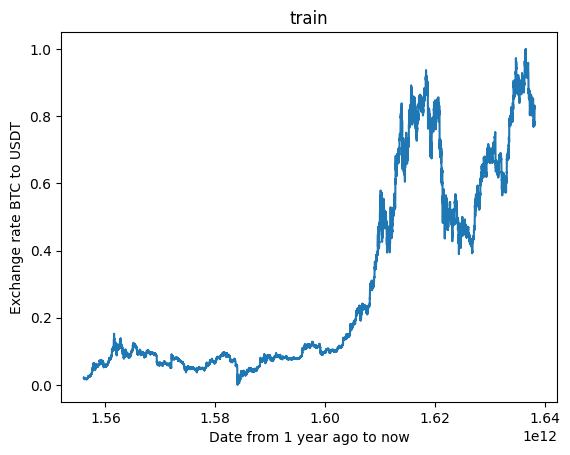

In [112]:
plt.plot(df_dates[:train_valid_border], train_norm)
plt.title('train')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

Text(0, 0.5, 'Exchange rate BTC to USDT')

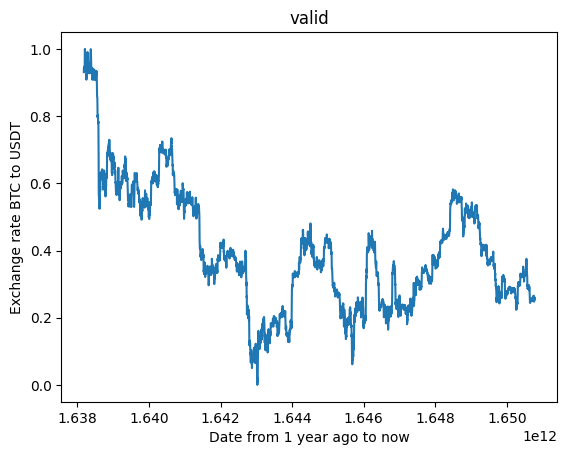

In [110]:
plt.plot(df_dates[train_valid_border:valid_test_border], valid_norm)
plt.title('valid')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

Text(0, 0.5, 'Exchange rate BTC to USDT')

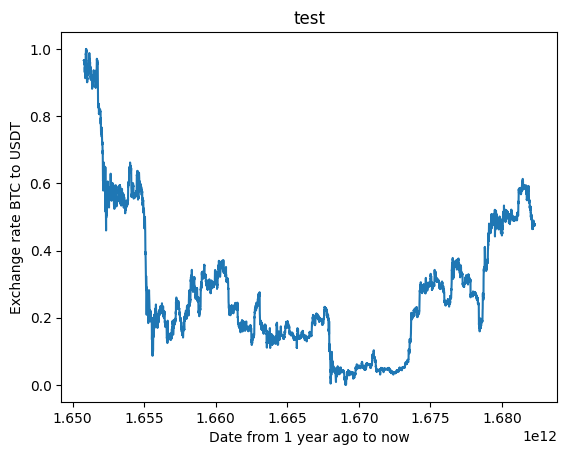

In [113]:
plt.plot(df_dates[valid_test_border:], test_norm)
plt.title('test')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

# Arrays => X, y  (Time series)

In [22]:
look_back = 720 # x will be last 720 hours for each y

train_gen = TimeseriesGenerator(train_norm, train_norm, length=look_back, batch_size=100)
valid_gen = TimeseriesGenerator(valid_norm, valid_norm, length=look_back, batch_size=1)
test_gen = TimeseriesGenerator(test_norm, test_norm, length=look_back, batch_size=1)

print('Number of batches in train_gen:', train_gen.__len__())

Number of batches in train_gen: 221


### X for first batch in train_gen (as pd dataframe)

In [23]:
pd.DataFrame(train_gen.__getitem__(0)[0][...,0])

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,0.021220,0.021185,0.021537,0.021706,0.022102,0.022242,0.022132,0.019989,0.020352,0.020074,...,0.057804,0.057463,0.057319,0.057623,0.057144,0.057162,0.057658,0.057700,0.058815,0.058797
1,0.021185,0.021537,0.021706,0.022102,0.022242,0.022132,0.019989,0.020352,0.020074,0.019357,...,0.057463,0.057319,0.057623,0.057144,0.057162,0.057658,0.057700,0.058815,0.058797,0.058939
2,0.021537,0.021706,0.022102,0.022242,0.022132,0.019989,0.020352,0.020074,0.019357,0.019447,...,0.057319,0.057623,0.057144,0.057162,0.057658,0.057700,0.058815,0.058797,0.058939,0.059646
3,0.021706,0.022102,0.022242,0.022132,0.019989,0.020352,0.020074,0.019357,0.019447,0.019877,...,0.057623,0.057144,0.057162,0.057658,0.057700,0.058815,0.058797,0.058939,0.059646,0.059792
4,0.022102,0.022242,0.022132,0.019989,0.020352,0.020074,0.019357,0.019447,0.019877,0.019610,...,0.057144,0.057162,0.057658,0.057700,0.058815,0.058797,0.058939,0.059646,0.059792,0.058908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.018053,0.018277,0.018206,0.017989,0.018221,0.018093,0.018292,0.018311,0.018420,0.018432,...,0.071644,0.071242,0.071875,0.071958,0.071779,0.071558,0.071102,0.070491,0.071163,0.070996
96,0.018277,0.018206,0.017989,0.018221,0.018093,0.018292,0.018311,0.018420,0.018432,0.018334,...,0.071242,0.071875,0.071958,0.071779,0.071558,0.071102,0.070491,0.071163,0.070996,0.071029
97,0.018206,0.017989,0.018221,0.018093,0.018292,0.018311,0.018420,0.018432,0.018334,0.018581,...,0.071875,0.071958,0.071779,0.071558,0.071102,0.070491,0.071163,0.070996,0.071029,0.070568
98,0.017989,0.018221,0.018093,0.018292,0.018311,0.018420,0.018432,0.018334,0.018581,0.018658,...,0.071958,0.071779,0.071558,0.071102,0.070491,0.071163,0.070996,0.071029,0.070568,0.071362


### y for first batch in train_gen (as pd dataframe)

In [24]:
pd.DataFrame(train_gen.__getitem__(0)[1])

,0
0,0.058939
1,0.059646
2,0.059792
3,0.058908
4,0.059931
...,...
95,0.071029
96,0.070568
97,0.071362
98,0.070724


# Training

In [27]:
data_dim = 1

model = Sequential()

model.add(InputLayer(input_shape=(look_back, data_dim)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))

early_stopping = EarlyStopping(patience=10)

model.compile('adam', loss='mae', metrics=['accuracy'])

model.fit_generator(train_gen, epochs=20, validation_data=valid_gen, callbacks=early_stopping)

Epoch 1/20


C:\Users\Evgeny\AppData\Local\Temp\ipykernel_5284\1957685753.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, epochs=20, validation_data=valid_gen, callbacks=early_stopping)


221/221 [==============================] - 81s 357ms/step - loss: 0.0905 - accuracy: 0.0000e+00 - val_loss: 0.0717 - val_accuracy: 0.0000e+00
Epoch 2/20
221/221 [==============================] - 75s 342ms/step - loss: 0.0542 - accuracy: 0.0000e+00 - val_loss: 0.0584 - val_accuracy: 0.0000e+00
Epoch 3/20
221/221 [==============================] - 75s 340ms/step - loss: 0.0474 - accuracy: 0.0000e+00 - val_loss: 0.0576 - val_accuracy: 0.0000e+00
Epoch 4/20
221/221 [==============================] - 74s 337ms/step - loss: 0.0477 - accuracy: 0.0000e+00 - val_loss: 0.0657 - val_accuracy: 0.0000e+00
Epoch 5/20
221/221 [==============================] - 79s 357ms/step - loss: 0.0306 - accuracy: 0.1878 - val_loss: 0.0207 - val_accuracy: 0.0014
Epoch 6/20
221/221 [==============================] - 73s 330ms/step - loss: 0.0081 - accuracy: 0.2416 - val_loss: 0.0164 - val_accuracy: 0.0000e+00
Epoch 7/20
221/221 [==============================] - 72s 329ms/step - loss: 0.0089 - accuracy: 0.1119 - 

# Test

In [32]:
loss, mae = model.evaluate_generator(test_gen, steps=len(test_gen))

C:\Users\Evgeny\AppData\Local\Temp\ipykernel_5284\28153521.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, mae = model.evaluate_generator(test_gen, steps=len(test_gen))


In [37]:
print(f'Loss: {loss} \nMean absolute error(mae): {mae}')

Loss: 0.004962409846484661 
Mean absolute error(mae): 0.0


In [77]:
y_pred = model.predict_generator(test_gen)


C:\Users\Evgeny\AppData\Local\Temp\ipykernel_5284\1890124827.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen)


In [79]:
y_true = test_gen.targets[721:]

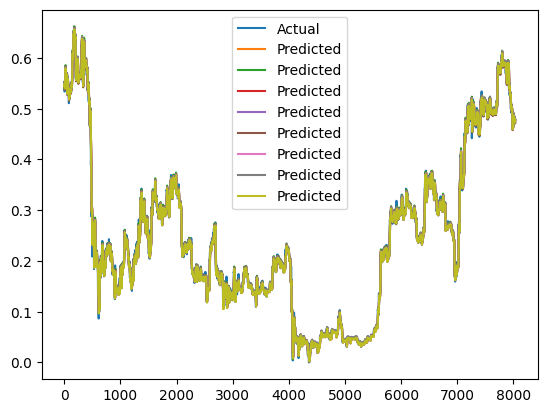

In [80]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()

# Predict exchange rate in 1 hour

In [122]:
model.save('./predict/saved_model.h5', save_format='h5')